This is a test Jupyter notebook with functions to get predictions from a pre-trained CNN model (Deep Learning model 2) for input cfDNA coordinate files from any folder. There are also functions to call various plotting functions from plotUtils for the predictions.

In [1]:
import sys
sys.path.insert(0,'/hpc/compgen/projects/fragclass/analysis/mvivekanandan/script/madhu_scripts')
import numpy as np
import os
import h5py
import pickle
import os
from datetime import datetime
import time

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import nn
from torch.nn.functional import one_hot

import SequenceCnnModelOld
import config
import utils
import plotUtils

import importlib

importlib.reload(SequenceCnnModelOld)
importlib.reload(config)
importlib.reload(utils)
importlib.reload(plotUtils)

Arguments in plotUtils are {'trainingAndValidationOutputsDirectory': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/trainingValidationPlotsAndMetrics/final_report_combined_model', 'coordStoreDirectory': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/OnlyTwoCoordinateFilesForTestingSmall', 'trainingEnformerStoreFile': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/EnformerOutputs/training_model_halfmil_attempt_2.hdf5', 'validationEnformerStoreFile': '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/EnformerOutputs/validation_model_halfmil_attempt_2.hdf5', 'trainingDataFile': 'trainingData.pkl', 'validationDataFile': 'validationData.pkl', 'trainingLossLearningRateFile': 'trainingLossLearningRateData.pkl', 'validationLossLearningRateFile': 'validationLossLearningRateData.pkl', 'checkpointsFile': 'modelCheckPoints', 'threshold': 0.5, 'batchSize': 128, 'learningRate': 1e-05, 'numEpochs': 20, 'useCosineLearningFunction': False, 'st

<module 'plotUtils' from '/hpc/compgen/projects/fragclass/analysis/mvivekanandan/script/madhu_scripts/plotUtils.py'>

In [6]:
#Directory from which input sequence are to be read. 
# coordStoreDir = "/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/latest_training_validation_data/trainingAndValidationExactlyClassBalancedHalfMil_0.1"
coordStoreDir = "/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/subsetClassBalancedCoordinateFiles"

#The directory where the model checkpoints are stored. 
modelStateDir = "/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/trainingValidationPlotsAndMetrics/20_aug_cnn_trials/29_08_19_52_23_model_2_dropout_0.25_bigger_subset_lr_0.0001"

#Directory where plots are to be stored. 
trainingValidationPlotsDir = "/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/trainingValidationPlotsAndMetrics/final_report_cnn_models"

arguments = {}
arguments["refGenomePath"] = config.filePaths.get("refGenomePath")

#Model hyperparameters 
arguments["threshold"] = config.modelHyperParameters.get("classificationThreshold")
arguments["batchSize"] = config.modelHyperParameters.get("batchSize")
arguments["learningRate"] = config.modelHyperParameters.get("learningRate")
arguments["numEpochs"] = config.modelHyperParameters.get("numberEpochs")
arguments["numWorkers"] = config.modelHyperParameters.get("numberOfWorkers")

#Model general configs
arguments["modelName"] = config.modelGeneralConfigs.get("modelName")
arguments["storePlots"] = config.modelGeneralConfigs.get("storePlots")
arguments["addLengthAsFeature"] = False
arguments["ddCfDnaPercentageThreshold"] = config.modelGeneralConfigs.get("ddCfDnaPercentageThreshold")

arguments["modelInputSequenceSize"] = 330
arguments["usePaddingForCnn"] = config.modelGeneralConfigs.get("usePaddingForCnn")

#Datasets
arguments["trainingCoordsDatasetName"] = config.datasetNames.get("trainingCoords")
arguments["trainingLabelsDatasetName"] = config.datasetNames.get("trainingLabels")
arguments["validationCoordsDatasetName"] = config.datasetNames.get("validationCoords")
arguments["validationLabelsDatasetName"] = config.datasetNames.get("validationLabels")
arguments["testCoordsDatasetName"] = config.datasetNames.get("testCoords")
arguments["testLabelsDatasetName"] = config.datasetNames.get("testLabels")


In [7]:
#get one hot encoded sequences from the coord store directory 
class PatientSequenceDataset(Dataset):
    def __init__(self, filename, sampleType):
        self.filename = filename
        self.sampleType = sampleType

    def __getitem__(self, index):     
        filepath = os.path.join(coordStoreDir, self.filename)
        
        with h5py.File(filepath, 'r') as f:
            coord = f[arguments[f"{self.sampleType}CoordsDatasetName"]][index]

            #Each sample should have only one label, it should be a single value instead of a numpy 1D array.The [0] is to make it a single value instead of a numpy array.
            # label = f['trainingLabels'][index][0]
            label = f[arguments[f"{self.sampleType}LabelsDatasetName"]][:][index]

            # if(arguments["interchangeLabels"] == True):
            #     labels = self.interchangeLabels(labels)

            sequenceOutputLength = arguments["modelInputSequenceSize"]
            expected_sequence_length = 196607 if sequenceOutputLength == "enformer" else sequenceOutputLength
            encoded_input_sequence, _, og_sequence_length = utils.getOneHotEncodedSequenceFromCoordinates(coord, arguments["refGenomePath"],
                                                                                         sequenceOutputLength, arguments["usePaddingForCnn"])
            #For some cases, the coordinates look fine, but the sequence fetched from the fasta file has size 0. 
            #If we pass such samples to enformer for predictions, we get Einops error, due to dimension mismatch.
            assert encoded_input_sequence.shape == (expected_sequence_length, 4), f"One of the samples did not have the right dimensions({(expected_sequence_length, 4)}). The sample index is {index}, shape is {encoded_input_sequence.shape}, filename is {self.filename} and index within the file is {index}"

        return encoded_input_sequence, label, og_sequence_length

    def __len__(self):
        filepath = os.path.join(coordStoreDir, self.filename)
        with h5py.File(filepath, 'r') as f:
            length = len(f[arguments[f"{self.sampleType}LabelsDatasetName"]][:])
        return length

In [8]:
def getPredictionsForAllData():
    cnnModel = SequenceCnnModelOld.SequenceCnnModelOld(0).to('cuda')

    #Load the previously trained model
    checkpoint_path = os.path.join(modelStateDir, "modelState")
    checkpoint = torch.load(checkpoint_path)
    cnnModel.load_state_dict(checkpoint)
    cnnModel.eval()

    criterion = nn.CrossEntropyLoss()
    modelInputLabelsToRet = {"training": [], "validation":[]}
    zeros = np.zeros(shape = (1, 2))
    modelPredictionsToRet = {"training": zeros, "validation": zeros}
    total_loss = {"training": 0, "validation": 0}
    batch_count = {"training": 0, "validation": 0}

    sampleTypes = ["training", "validation"]

    for sampleType in sampleTypes:
        for filename in os.listdir(coordStoreDir):

            dataset = PatientSequenceDataset(filename, sampleType)
            dataloader = DataLoader(dataset, batch_size=arguments["batchSize"], 
                                            num_workers=arguments["numWorkers"])
            batch_count[sampleType] += len(dataloader)

            num_batches = len(dataloader)
            store_plotting_data_interval = 3 if num_batches > 3000 else 1

            for i, data in enumerate(dataloader):
                sequence, class_labels, og_sequence_length = data
                if torch.cuda.is_available():
                    sequence = sequence.to("cuda")
                    class_labels = class_labels.to("cuda")
                
                #Reshaping to have the structure (batches, channels, sequence_length, 4)
                batches, sequence_length, one_hot_base_length = sequence.shape
                sequence = sequence.reshape(batches, 1, sequence_length, one_hot_base_length)
                class_labels = class_labels.to(torch.int64).flatten()
                og_sequence_length = og_sequence_length.reshape(len(og_sequence_length), 1).to("cuda")

                probabilityLabels = one_hot(class_labels, num_classes=2).to(torch.float32)
                modelPrediction = cnnModel(sequence, og_sequence_length, arguments["addLengthAsFeature"])

                loss = criterion(modelPrediction, probabilityLabels)
                total_loss[sampleType] += loss.item()

                if(i % store_plotting_data_interval == 0):
                    modelInputLabelsToRet[sampleType].extend(class_labels.cpu())
                    modelPredictionsToRet[sampleType] = np.row_stack([modelPredictionsToRet[sampleType], modelPrediction.detach().cpu().numpy()])

                # if(i % 10 == 0):
                #     print(f"Completed predictions for batch {i}")
            
            print(f"Finished all {sampleType} batches for filename {filename}. Storing the data now!!!")

    #----------------------------------------- START PLOTTING ------------------------------------------
    trainingPlotsData = {}
    trainingPlotsData["labels"] = modelInputLabelsToRet["training"]
    trainingPlotsData["predictions"] = modelPredictionsToRet["training"][1:, :]
    trainingPlotsData["loss"] = total_loss["training"]/batch_count["training"]
    num_labels_training = len(modelInputLabelsToRet["training"])
    shape_predictions_training = modelPredictionsToRet["training"][1:, :].shape
    loss_training = trainingPlotsData["loss"]
    print(f"Data for training: {num_labels_training}, {shape_predictions_training} and {loss_training}")

    # plotsData["loss"] = avg_loss_per_batch
    validationPlotsData = {}
    validationPlotsData["labels"] = modelInputLabelsToRet["validation"]
    validationPlotsData["predictions"] = modelPredictionsToRet["validation"][1:, :]
    validationPlotsData["loss"] = total_loss["validation"]/batch_count["validation"]
    num_labels_validation = len(modelInputLabelsToRet["validation"])
    shape_predictions_validation = modelPredictionsToRet["validation"][1:, :].shape
    loss_validation = validationPlotsData["loss"]
    print(f"Data for validation: {num_labels_validation}, {shape_predictions_validation} and {loss_validation}")

    return trainingPlotsData, validationPlotsData

Start time is 1702418988.9592707
Finished all training batches for filename L20-M35.recipient.hdf5. Storing the data now!!!
Finished all training batches for filename L10-M24.donor.hdf5. Storing the data now!!!
Finished all training batches for filename L3-M1-5.recipient.hdf5. Storing the data now!!!
Finished all training batches for filename L9b-W2.donor.hdf5. Storing the data now!!!
Finished all training batches for filename L6-M12.donor.hdf5. Storing the data now!!!
Finished all training batches for filename L13-M24.donor.hdf5. Storing the data now!!!
Finished all training batches for filename L7-M25.donor.hdf5. Storing the data now!!!
Finished all training batches for filename L16-M23.recipient.hdf5. Storing the data now!!!
Finished all training batches for filename L1-M13.recipient.hdf5. Storing the data now!!!
Finished all training batches for filename L5-M12.recipient.hdf5. Storing the data now!!!
Finished all training batches for filename L9b-M2.recipient.hdf5. Storing the data

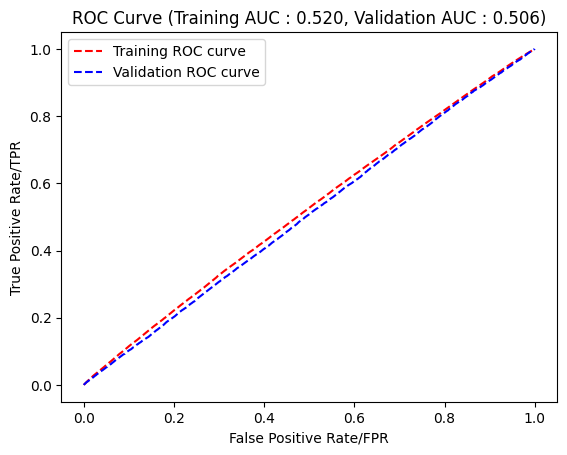

<Figure size 640x480 with 0 Axes>

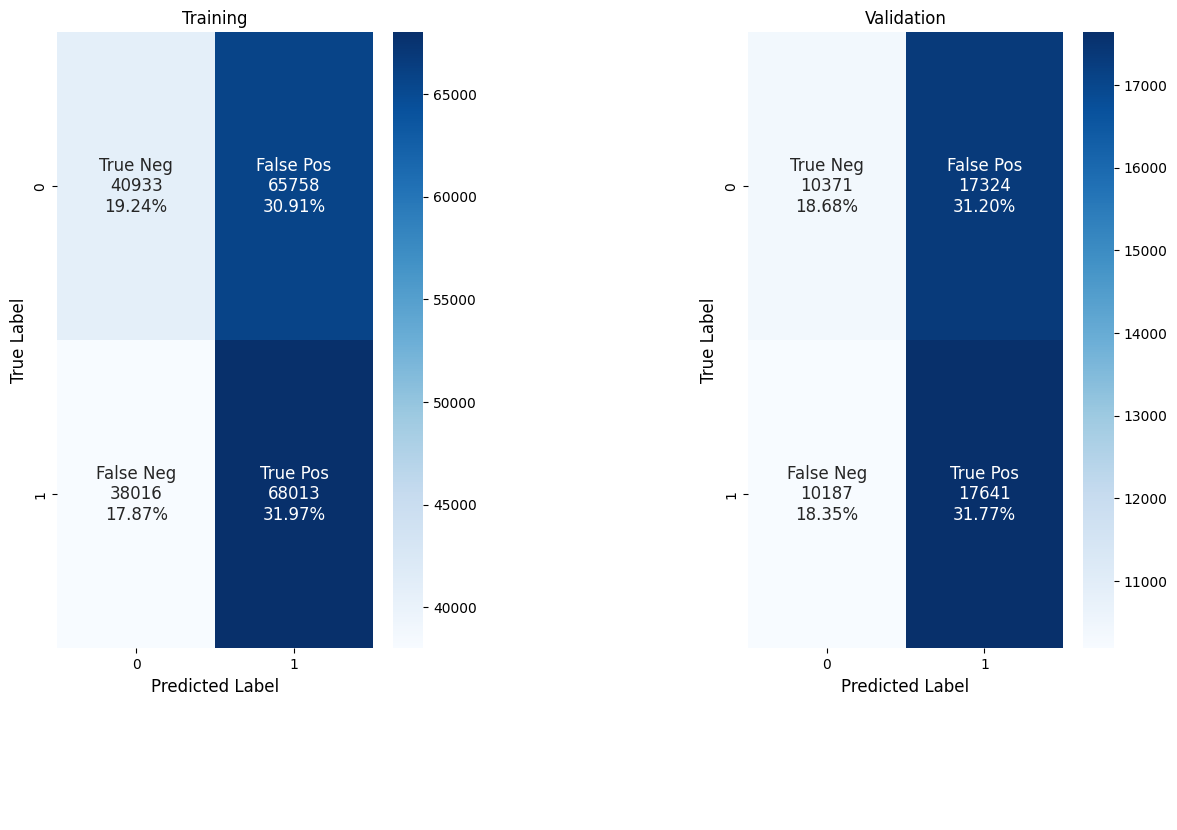

End time is 1702419426.836208


<Figure size 640x480 with 0 Axes>

In [9]:
if __name__ == '__main__':
    print(f"Start time is {time.time()}")           
    now = datetime.now()
    filename_extension = now.strftime("%d_%m_%H_%M_%S")
    modelname = "dropout_0.25"
    plots_directory_name = filename_extension + "_" + modelname
    plots_directory_path = os.path.join(trainingValidationPlotsDir, plots_directory_name)
    
    os.mkdir(plots_directory_path)

    trainingPlotsData, validationPlotsData = getPredictionsForAllData()
    
    output_probabilities, class_predictions = plotUtils.getClassPredictionsAndProbsFromOutput(trainingPlotsData, validationPlotsData)
    plotUtils.storeAucAndRocCurve(output_probabilities, trainingPlotsData, validationPlotsData, plots_directory_path)
    plotUtils.storeConfusionMatrixHeatMap(trainingPlotsData, validationPlotsData, class_predictions, plots_directory_path)
    print(f"End time is {time.time()}")   

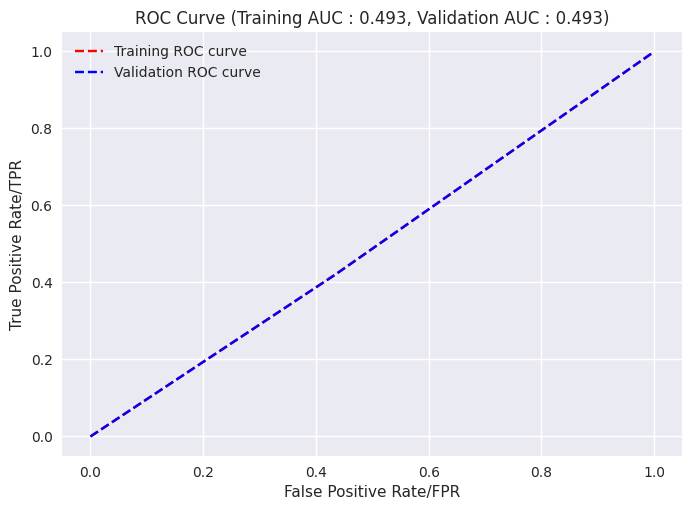

<Figure size 800x550 with 0 Axes>

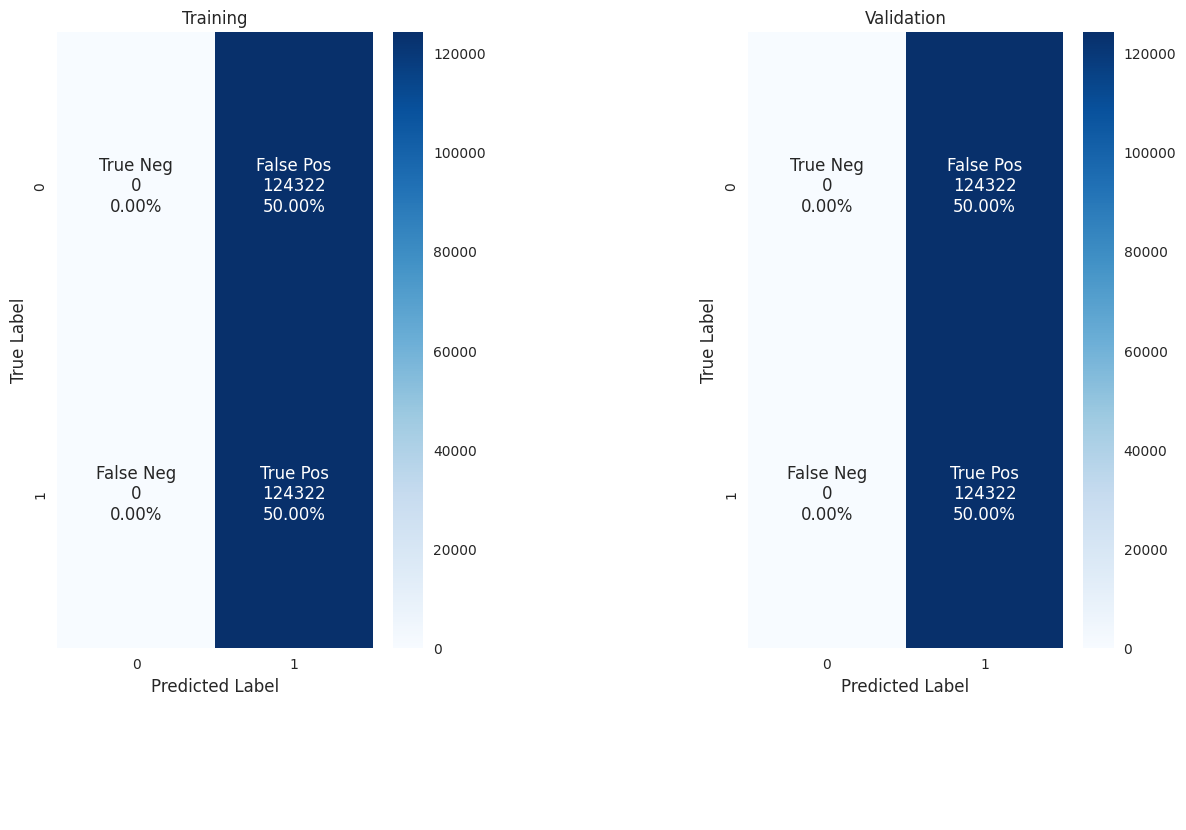

<Figure size 800x550 with 0 Axes>

In [31]:
output_probabilities, class_predictions = plotUtils.getClassPredictionsAndProbsFromOutput(trainingPlotsData, validationPlotsData)
plotUtils.storeAucAndRocCurve(output_probabilities, trainingPlotsData, validationPlotsData, plotsDir)
plotUtils.storeConfusionMatrixHeatMap(trainingPlotsData, validationPlotsData, class_predictions, plotsDir)

In [21]:
trainingPickleFilePath = os.path.join(plotsDir, "trainingData.pkl")
with open(trainingPickleFilePath, 'rb') as file:
    trainingData = pickle.load(file)

validationPickleFilePath = os.path.join(plotsDir, "validationData.pkl")
with open(validationPickleFilePath, 'rb') as file:
    validationData = pickle.load(file)

array([[ 9.36798096, -6.88308001],
       [ 9.8822422 , -7.00250101],
       [ 9.56910896, -6.89028502],
       [ 9.55965042, -6.79280996],
       [-6.3423171 ,  9.97739887],
       [ 9.145751  , -6.92352295],
       [-6.12450743,  9.65402603],
       [ 9.69629192, -6.67247343],
       [-6.80380869,  9.44785023],
       [-6.15502262,  9.41934586],
       [10.08178329, -6.7562542 ],
       [ 9.88831139, -6.70687342],
       [-6.85340166,  9.8073616 ],
       [-6.52343845,  9.83964062],
       [ 9.37318039, -6.57545614],
       [-6.61108971,  9.72640228],
       [ 9.63218117, -6.58315802],
       [-6.82591677,  9.8241024 ],
       [10.13308716, -6.78114748],
       [ 9.89259911, -7.07097101],
       [ 9.59699059, -6.83325434],
       [-6.79104805,  9.86180687],
       [ 9.30092812, -6.96748781],
       [ 9.40816498, -6.59699488],
       [ 9.17284679, -6.75187445]])

In [24]:
print(trainingData["labels"][0:50])
print(trainingData["predictions"][0:25])

[tensor(0), tensor(0), tensor(0), tensor(0), tensor(1), tensor(0), tensor(1), tensor(0), tensor(1), tensor(1), tensor(0), tensor(0), tensor(1), tensor(1), tensor(0), tensor(1), tensor(0), tensor(1), tensor(0), tensor(0), tensor(0), tensor(1), tensor(0), tensor(0), tensor(0), tensor(1), tensor(0), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(0), tensor(1), tensor(0), tensor(0), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(0), tensor(0), tensor(0), tensor(1), tensor(1), tensor(0), tensor(0)]
[[ 9.36798096 -6.88308001]
 [ 9.8822422  -7.00250101]
 [ 9.56910896 -6.89028502]
 [ 9.55965042 -6.79280996]
 [-6.3423171   9.97739887]
 [ 9.145751   -6.92352295]
 [-6.12450743  9.65402603]
 [ 9.69629192 -6.67247343]
 [-6.80380869  9.44785023]
 [-6.15502262  9.41934586]
 [10.08178329 -6.7562542 ]
 [ 9.88831139 -6.70687342]
 [-6.85340166  9.8073616 ]
 [-6.52343845  9.83964062]
 [ 9.37318039 -6.57545614]
 [-6.61108971  9.72640228]
 [ 9.63218117 -6.